In [2]:
integral_count = 1000

def integral_by_trapezoidal_rule(f, start_x, end_x):
    sum = 0
    width = (end_x - start_x) / integral_count
    for i in range(integral_count):
        area = width * (f(start_x + i*width) + f(start_x + (i + 1)*width)) / 2
        sum += area
    
    return sum

In [65]:
# 方程式を定義
import numpy as np
import math
import functools

def func_r(q):
    value = q / (1 - b + b * q) ** 2
    return value


def func_g_integrand(z, m, q):
    integrand = (1 / math.sqrt(2 * np.pi)) * math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a * func_r(q)) * z)) ** 2
    return integrand

    
def func_f_integrand(z, m, q):
    integrand =  (1 / math.sqrt(2 * np.pi)) * math.exp(-z**2/2) * np.tanh(b * (m + math.sqrt(a * func_r(q)) * z))
    return integrand
    

def func_g(m, q):
    func = functools.partial(func_g_integrand, m=m, q=q)
    value =  integral_by_trapezoidal_rule(func,  -100, 100)
    return value
    
    
def func_f(m, q):
    func = functools.partial(func_f_integrand, m=m, q=q)
    value = integral_by_trapezoidal_rule(func,  -100, 100)
    return value


# ニュートン法の更新式を定義

# def differential_of_sqrt_r(q):
#     value_1 = 1 / (2 * math.sqrt(r(q)) )
#     denominator_of_value_2 = 1 - 2*q * (b-1-q) - (b-1-q)**2
#     numerator_of_value_2 = (1 - (b-1-q)**2 )**2
#     return value_1 * numerator_of_value_2 / denominator_of_value_2
    

# # j11
# def j_11_integrand(z, m, q):
#     integrand =  (1 / math.sqrt(2 * np.pi)) * math.exp(-z**2/2) / np.cosh(b * (m + math.sqrt(a * r(q)) * z))**2    * b
#     return integrand
    
# def j_11(m, q):
#     func = functools.partial(j_11_integrand, m=m, q=q)
#     return 1 - integral_by_trapezoidal_rule(func, -100, 100)    


# # j12
# def j_12_integrand(z, m, q):
#     integrand =  (1 / math.sqrt(2 * np.pi)) * math.exp(-z**2/2) / np.cosh(b * (m + math.sqrt(a * r(q)) * z))**2    * math.sqrt(a)*z* differential_of_sqrt_r(q)
#     return integrand
    
# def j_12(m, q):
#     func = functools.partial(j_12_integrand, m=m, q=q)
#     return 1 - integral_by_trapezoidal_rule(func, -100, 100)

    
# # j21
# def j_21_integrand(z, m, q):
#     integrand =  (1 / math.sqrt(2 * np.pi)) * math.exp(-z**2/2) / np.cosh(b * (m + math.sqrt(a * r(q)) * z))**2    * b    * 2*np.tanh(b * (m + math.sqrt(a * r(q)) * z))
#     return integrand
    
# def j_21(m, q):
#     func = functools.partial(j_21_integrand, m=m, q=q)
#     return 1 - integral_by_trapezoidal_rule(func, -100, 100)
    

# # j22
# def j_22_integrand(z, m, q):
#     integrand =  (1 / math.sqrt(2 * np.pi)) * math.exp(-z**2/2) / np.cosh(b * (m + math.sqrt(a * r(q)) * z))**2    * math.sqrt(a)*z* differential_of_sqrt_r(q)    *2*np.tanh(b * (m + math.sqrt(a * r(q)) * z))
#     return integrand
    
# def j_22(m, q):
#     func = functools.partial(j_22_integrand, m=m, q=q)
#     return 1 - integral_by_trapezoidal_rule(func, -100, 100)


# # calculate det
# def get_matrics_info(m, q):
#     j11 = j_11(m, q)
#     j12 = j_12(m, q)
#     j21 = j_21(m, q)
#     j22 = j_22(m, q)
#     return {"det": j11*j22 - j12*j21, "matrics":[[0, 0, 0], [0, j11, j12], [0, j21, j22]]}

In [66]:
# m, q のプロット

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

a = 0.1
b = 3

def plot_f_and_g(plot_num, zlim, args):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d', zlim=(-1.0, 1.0))
    ax.set_title("f(m,q) & g(m,q)", size = 20)

    ax.set_xlabel("m", size = 20)
    ax.set_ylabel("q", size = 20)
    ax.set_zlabel("", size = 20)

    x = np.linspace(args["m_min"], args["m_max"], plot_num)
    y = np.linspace(args["q_min"], args["q_max"], plot_num)

    X, Y = np.meshgrid(x, y)
    X = X.flatten()
    Y = Y.flatten()
    X, Y
    F = np.ndarray([])
    G = np.ndarray([])
    for i in range(len(Y)-1):
        #print(func_f(X[i], Y[i]))
        F = np.append(F, func_f(X[i], Y[i]))
        G = np.append(G, func_g(X[i], Y[i]))


    ax.plot(X, Y, F, color = "red", label='f (m,q)')
    ax.plot(X, Y, G, color = "green", label='g (m,q)')

    # これ呼ばないとラベルでない
    plt.legend()

    plt.show()

In [84]:
import numpy as np
'''
① a,bをメッシュに区切る
② 特定のa,bにおいて、m,qを0~1でメッシュに区切る
③ m,qのメッシュ全てでf,gを計算する
④ f,gがともに0に一番近いときのm,qを答えとして採用
'''

mesh_num = 15
delta = pow(10, -2)

A = np.linspace(0.01, 0.21, mesh_num)
T = np.linspace(0.01, 5.01, mesh_num)

# ①のメッシュ
a_arr, t_arr = np.meshgrid(A, T)
a_arr = a_arr.flatten()
t_arr = t_arr.flatten()

answer_m = []
answer_q = []
for i in range(len(a_arr)):
#     print("i:",i, "番目です")
    M = np.linspace(0.01, 1.01, 20)
    Q = np.linspace(0.01, 1.01, 20)
    
    # ②のメッシュ
    m, q = np.meshgrid(M, Q)
    m = m.flatten()
    q = q.flatten()

    m_i = []
    q_i = []

    a = a_arr[i]
    # βに変換しておく
    b = 1/t_arr[i]

    # ③,④
    for j in range(len(m)):
        f = func_f(m[j], q[j])
        g = func_g(m[j], q[j])
#         print("m={0}, q ={1} => delta = {2}".format(m[j], q[j], f**2 + g**2))
        if f**2 < delta or g**2 < delta:
            m_i.append(m[j])
            q_i.append(q[j])
    
    m_i = [0] if len(m_i) == 0 else list(set(m_i))
    q_i = [0] if len(q_i) == 0 else list(set(q_i))
    
    unque_m_i = max(m_i)
    unque_q_i = max(q_i)
#     print(unque_m_i, unque_q_i)
    answer_m.append(unque_m_i)
    answer_q.append(unque_q_i)


# csv書き出し
import csv

f = open("./result_at_15_mq_20.csv", "w")
writer = csv.writer(f)

for i in range(len(a_arr)):
    tmp = [a_arr[i], t_arr[i], answer_m[i], answer_q[i]]
    writer.writerow(tmp)

f.close()

[[0.01 0.01 1.01 1.01]
 [0.06 0.01 1.01 1.01]
 [0.11 0.01 1.01 1.01]
 [0.16 0.01 1.01 1.01]
 [0.21 0.01 1.01 1.01]
 [0.01 1.26 0.01 1.01]
 [0.06 1.26 0.01 1.01]
 [0.11 1.26 0.26 1.01]
 [0.16 1.26 0.26 1.01]
 [0.21 1.26 0.26 1.01]
 [0.01 2.51 0.01 1.01]
 [0.06 2.51 0.01 1.01]
 [0.11 2.51 0.01 1.01]
 [0.16 2.51 0.01 1.01]
 [0.21 2.51 0.01 1.01]
 [0.01 3.76 0.01 1.01]
 [0.06 3.76 0.26 1.01]
 [0.11 3.76 0.26 1.01]
 [0.16 3.76 0.26 1.01]
 [0.21 3.76 0.51 1.01]
 [0.01 5.01 0.01 1.01]
 [0.06 5.01 0.01 1.01]
 [0.11 5.01 0.01 1.01]
 [0.16 5.01 0.01 1.01]
 [0.21 5.01 0.01 1.01]]


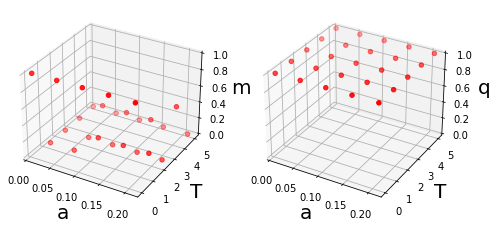

In [82]:
# csv 読み出し
result_arr = np.loadtxt("./result.csv", delimiter=",")

print(result_arr)

result_a = result_arr[:, 0]
result_b = result_arr[:, 1]
result_m = result_arr[:, 2]
result_q = result_arr[:, 3]

# プロット
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(121, projection='3d', zlim=(0, 1.0))

ax.set_xlabel("a", size = 20)
ax.set_ylabel("T", size = 20)
ax.set_zlabel("m", size = 20)

ax.scatter(result_a, result_b, result_m, color = "red")

# csv 読み出し
ax_2 = fig.add_subplot(122, projection='3d', zlim=(0, 1.0))

ax_2.set_xlabel("a", size = 20)
ax_2.set_ylabel("T", size = 20)
ax_2.set_zlabel("q", size = 20)

ax_2.scatter(result_a, result_b, result_q, color = "red")


plt.show()